# 2D f-Plane equations

In this code we will solve the horizontal rotating 2D boussinesq equations linearized around a state of rest, which can be written in vector form as: 
$$
\frac{\partial \mathbf{u}}{\partial t} + \mathbf{f} \times \mathbf{u} + \nabla \phi  = 0
$$

$$
\nabla \cdot \mathbf{u} =0
$$


where $\mathbf{u} = (u, v)$ is the velocity in the 2D x-y plane, and $\phi$ is the dynamical pressure. $\mathbf{f} = fo \mathbf{k}$ is the coriollis force, where $f_o$ is a constant.


Here we will solve the equations for a simple scenario. 

In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
# Parameters
Lx, Ly = 50e3, 50e3 # m
Nx, Ny = 256, 256

fo = 1e-4 # s-1
beta = 1e-11 

dealias = 3/2
stop_sim_time = 10 * 24 * 3600 # s
timestepper = d3.RK222
max_timestep = 3600 # s # We might be able to take longer time steps, but this is the time we want to save output at
dtype = np.float64


u0 = .3

sigma = 4e3

kappa = 0.05* u0**2 * max_timestep

In [3]:
kappa

16.2

In [4]:
# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-Lx, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(-Ly, Ly), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,ybasis))
c = dist.Field(name='p', bases=(xbasis,ybasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis))
#w = dist.Field(name='w', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')

x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist)

We will force the system with a time varying forcing (sinusoidal in time), which will be applied to a local region (localized using a gaussian). 

The goal will be to see how waves emanate from this forcing region. 

In [5]:
# Setup Forcing 
# Fxz = dist.Field(name='Fxz', bases=(xbasis,zbasis))

# sigma = 0.05 # sets the size of the forcing region.
# Fxz['g'] = np.exp(-((x)**2 + (z)**2) / (2 * sigma**2))

# t = dist.Field()
# forcing_freq = 0.8*N2 # You may need to change (we are setting this relative to N2 for physical meangingfulness)
# Ft = np.sin(forcing_freq*t)

In [6]:
#from dedalus.extras.plot_tools import plot_bot_2d
#plot_bot_2d(Fxz,title="Region where forcing is applied");

In [7]:
problem = d3.IVP([p, u, c, tau_p], namespace=locals())

In principle the system can solved quite easily, using Dedalus. Notice that the equations are entered in almost readable form. 

>@ is the dot product, * is just simple multiplication. 

In [8]:
problem.add_equation("dt(u) + grad(p) - fo*(u@ey)*ex + fo*(u@ex)*ey= 0")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("dt(c) - kappa*lap(c)= - u@grad(c)")
problem.add_equation("integ(p) = 0");


In [9]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2025-02-19 08:12:17,406 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 2.9e+01/s
2025-02-19 08:12:17,671 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 4.3e+01/s
2025-02-19 08:12:17,951 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 2s, Rate: 4.5e+01/s
2025-02-19 08:12:18,229 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 2s, Rate: 4.6e+01/s
2025-02-19 08:12:18,507 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 2s, Rate: 4.6e+01/s
2025-02-19 08:12:18,785 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 4.6e+01/s
2025-02-19 08:12:19,063 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 2s, Remaining: 1s, Rate: 4.6e+01/s
2025-02-19 08:12:19,342 subsystems 0/1 INFO :: Building subprobl

In [10]:
# Initial conditions


u['g'] = u0


xn = list(np.linspace(-Lx, Lx, 4))
yn = list(np.linspace(-Ly, Ly, 4))

c['g'] = 0
for xo in xn:
    for yo in yn:
        
        gauss_bump = np.exp( - ((x -  xo)**2 + (y - yo)**2) / (2 * sigma**2) )

        c['g'] = c['g'] + gauss_bump

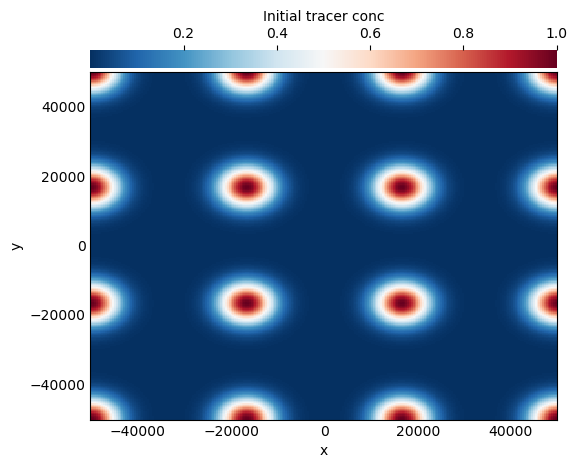

In [11]:
from dedalus.extras.plot_tools import plot_bot_2d
plot_bot_2d(c,title="Initial tracer conc");

The next few lines setup the way that the data will be saved.

In [12]:
# Analysis
sim_dt =  3600
max_writes = stop_sim_time/sim_dt
data_fname = 'snapshots'
snapshots = solver.evaluator.add_file_handler(data_fname, 
                                              sim_dt=sim_dt, 
                                              max_writes=max_writes)
snapshots.add_task(u, name='uvec')
snapshots.add_task(p, name='pressure')
snapshots.add_task(c, name='tracer')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [13]:
# CFL (adapt time step as needed)
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [14]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2025-02-19 08:12:20,806 __main__ 0/1 INFO :: Starting main loop
2025-02-19 08:12:22,533 __main__ 0/1 INFO :: Iteration=1, Time=3.600000e+03, dt=3.600000e+03
2025-02-19 08:12:23,106 __main__ 0/1 INFO :: Iteration=11, Time=3.960000e+04, dt=3.600000e+03
2025-02-19 08:12:23,836 __main__ 0/1 INFO :: Iteration=21, Time=5.760000e+04, dt=1.800000e+03
2025-02-19 08:12:24,579 __main__ 0/1 INFO :: Iteration=31, Time=6.660000e+04, dt=9.000000e+02
2025-02-19 08:12:25,283 __main__ 0/1 INFO :: Iteration=41, Time=7.110000e+04, dt=4.500000e+02
2025-02-19 08:12:25,738 __main__ 0/1 INFO :: Iteration=51, Time=7.560000e+04, dt=4.500000e+02
2025-02-19 08:12:26,444 __main__ 0/1 INFO :: Iteration=61, Time=7.908357e+04, dt=3.483568e+02
2025-02-19 08:12:27,139 __main__ 0/1 INFO :: Iteration=71, Time=8.234110e+04, dt=3.257531e+02
2025-02-19 08:12:27,827 __main__ 0/1 INFO :: Iteration=81, Time=8.577770e+04, dt=3.436606e+02
2025-02-19 08:12:28,507 __main__ 0/1 INFO :: Iteration=91, Time=8.992093e+04, dt=4.143220e+

# Plot the solution 

In [15]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import dedalus.public as d3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr

In [16]:
simdata = './snapshots/snapshots_s1.h5'

In [17]:
# See what is in the data files
with h5py.File(simdata, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (9 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_5fefed29d576967008127fc7b486b28331a3133e', 'y_hash_5fefed29d576967008127fc7b486b28331a3133e']
<HDF5 group "/tasks" (3 members)>
['pressure', 'tracer', 'uvec']


In [18]:
# Actually read in data files
with h5py.File(simdata, mode='r') as file:
    
    #b_data = np.squeeze(np.array(file['tasks']['buoyancy']))
    #print('b shape: ' + str(b_data.shape))
    u_data = np.squeeze(np.array(file['tasks']['uvec']))
    print('u_data: ' + str(u_data.shape))
    p_data = np.squeeze(np.array(file['tasks']['pressure']))
    print('p_data: ' + str(p_data.shape))
    c_data = np.squeeze(np.array(file['tasks']['tracer']))
    print('c_data: ' + str(c_data.shape))
    #vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    #div_data = np.squeeze(np.array(file['tasks']['divergence']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])/3600
    print(sim_time_ary.shape)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    

u_data: (240, 2, 256, 256)
p_data: (240, 256, 256)
c_data: (240, 256, 256)
(240,)


In [19]:
# Put data in xarray, as it is nice way to keep things organized
ds_sim = xr.Dataset()

#ds_sim['b'] = xr.DataArray(b_data, coords = {'time':sim_time_ary, 'x':x, 'z':z})
ds_sim['p'] = xr.DataArray(p_data, coords = {'time':sim_time_ary, 'x':x, 'y':y})
ds_sim['c'] = xr.DataArray(c_data, coords = {'time':sim_time_ary, 'x':x, 'y':y})
ds_sim['u'] = xr.DataArray(u_data[:,0,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':x, 'y':y})
ds_sim['v'] = xr.DataArray(u_data[:,1,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':x, 'y':y})

In [20]:
ds_sim

<xarray.Dataset>
Dimensions:  (time: 240, x: 256, y: 256)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 236.1 237.0 238.1 239.1
  * x        (x) float64 -5e+04 -4.961e+04 -4.922e+04 ... 4.922e+04 4.961e+04
  * y        (y) float64 -5e+04 -4.961e+04 -4.922e+04 ... 4.922e+04 4.961e+04
Data variables:
    p        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    c        (time, x, y) float64 1.0 0.9952 0.9811 ... 0.2418 0.2293 0.2166
    u        (time, x, y) float64 0.3 0.3 0.3 0.3 ... -0.3837 -0.3837 -0.3837
    v        (time, x, y) float64 0.3 0.3 0.3 0.3 ... 0.1803 0.1803 0.1803

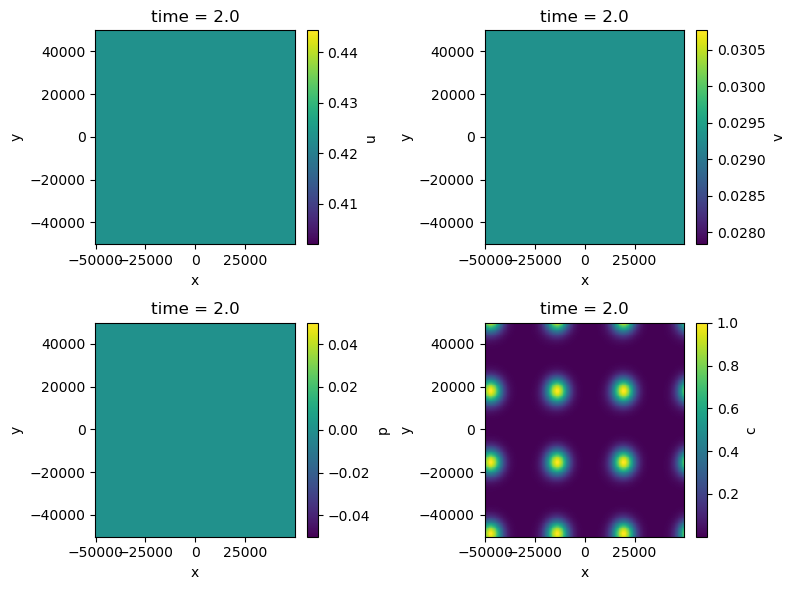

In [21]:
plt.figure(figsize=(8, 6.))
time_id = 2
plt.subplot(2,2,1)
ds_sim.u.isel(time=time_id).plot(x='x')

plt.subplot(2,2,2)
ds_sim.v.isel(time=time_id).plot(x='x')

plt.subplot(2,2,3)
ds_sim.p.isel(time=time_id).plot(x='x')

plt.subplot(2,2,4)
ds_sim.c.isel(time=time_id).plot(x='x')

plt.tight_layout()

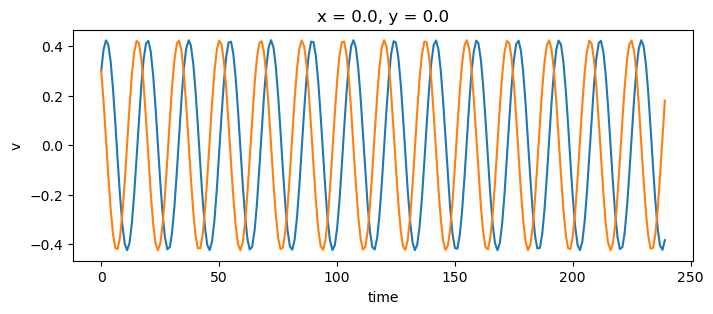

In [22]:
plt.figure(figsize=(8, 3))
#plt.pcolormesh(x, y, b_data[20, :,:].T)
ds_sim.u.sel(x=0, y=0, method='nearest').plot()
ds_sim.v.sel(x=0, y=0, method='nearest').plot()

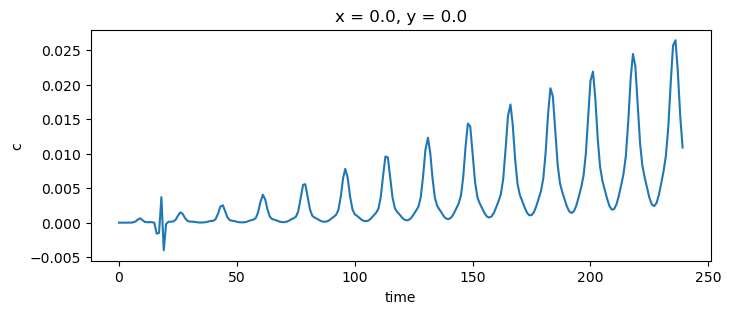

In [23]:
plt.figure(figsize=(8, 3))
#plt.pcolormesh(x, y, b_data[20, :,:].T)
ds_sim.c.sel(x=0, y=0, method='nearest').plot()
#ds_sim.v.sel(x=0, y=0, method='nearest').plot()

Make a movie of a certain field

In [24]:
def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [25]:
# This function needs to be modified as needed if you want to make other movies
def plot_fun(time_idx): 
    vmin=-0.6
    fig = plt.figure(figsize=(6, 2))
    
    ds_sim.c.isel(time=time_idx).plot(x='x', vmin=vmin)
    plt.gca().set_aspect('equal')
    
    plt.title(f"{sim_time_ary[time_idx]:.2f} hrs")

    plt.tight_layout()
    

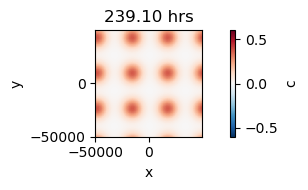

In [26]:
plot_fun(-1)

In [27]:
fname = 'GW.gif'
create_animation(plot_fun, range(0, len(sim_time_ary), 1), filename=fname)

Animation at FPS=18 will last for 13.333333333333334 seconds
